In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

try:
    if not os.path.isdir('/content/pyTorchWrapper'):
        raise FileNotFoundError
except FileNotFoundError:
    print("(◕‿◕✿) Downloading pyTorchWrapper from GitHub.")
    os.system(f'git clone https://github.com/shuliu2017/pyTorchWrapper.git')
except Exception as e:
    print(f"(◕‿◕✿) An unexpected error occurred: {e}")

sys.path.append('/content/pyTorchWrapper')

(◕‿◕✿) Downloading pyTorchWrapper from GitHub.


In [ ]:
import zipfile

# Path to your zip file
zip_path = '/content/drive/My Drive/dataset/garbage_classification/GARBAGE CLASSIFICATION 3.v2-gc1.yolov8.zip'  # Update this with the actual path

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Verify that the dataset is extracted
!ls /content/dataset


data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import glob

class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = []

        # Gather image files that contain only one object
        for label_file in glob.glob(os.path.join(label_dir, '*.txt')):
            with open(label_file, 'r') as f:
                lines = f.readlines()
                if len(lines) == 1:
                    img_file = label_file.replace(label_dir, img_dir).replace('.txt', '.jpg')
                    if os.path.isfile(img_file):
                        self.img_files.append(img_file)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        label_path = img_path.replace(self.img_dir, self.label_dir).replace('.jpg', '.txt')

        image = Image.open(img_path).convert("RGB")
        with open(label_path, 'r') as f:
            label = f.readline().strip().split()
            class_id = int(label[0])

        if self.transform:
            image = self.transform(image)

        return image, class_id



In [ ]:
import simple_torch_wrapper as  stw

In [ ]:
# image_processor = transformers.AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
# normalize =transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

In [ ]:
# Paths
train_img_dir = "/content/dataset/train/images"
train_label_dir = "/content/dataset/train/labels"

# Transforms
"""
transform = transforms.Compose([
    transforms.Resize((416, 416)), # Resize to YOLO input size
    transforms.ToTensor()
])
""";
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the required input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset and DataLoader
train_dataset = YOLODataset(img_dir=train_img_dir, label_dir=train_label_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

# Example usage
for images, labels in train_loader:
    print(images.shape)  # Batch of images
    print(labels.shape)  # Corresponding labels
    break


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([4, 3, 224, 224])
torch.Size([4])


In [ ]:
valid_img_dir = "/content/dataset/valid/images"
valid_label_dir = "/content/dataset/valid/labels"

# Create Dataset and DataLoader
valid_dataset = YOLODataset(img_dir=valid_img_dir, label_dir=valid_label_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=2)

## EDA

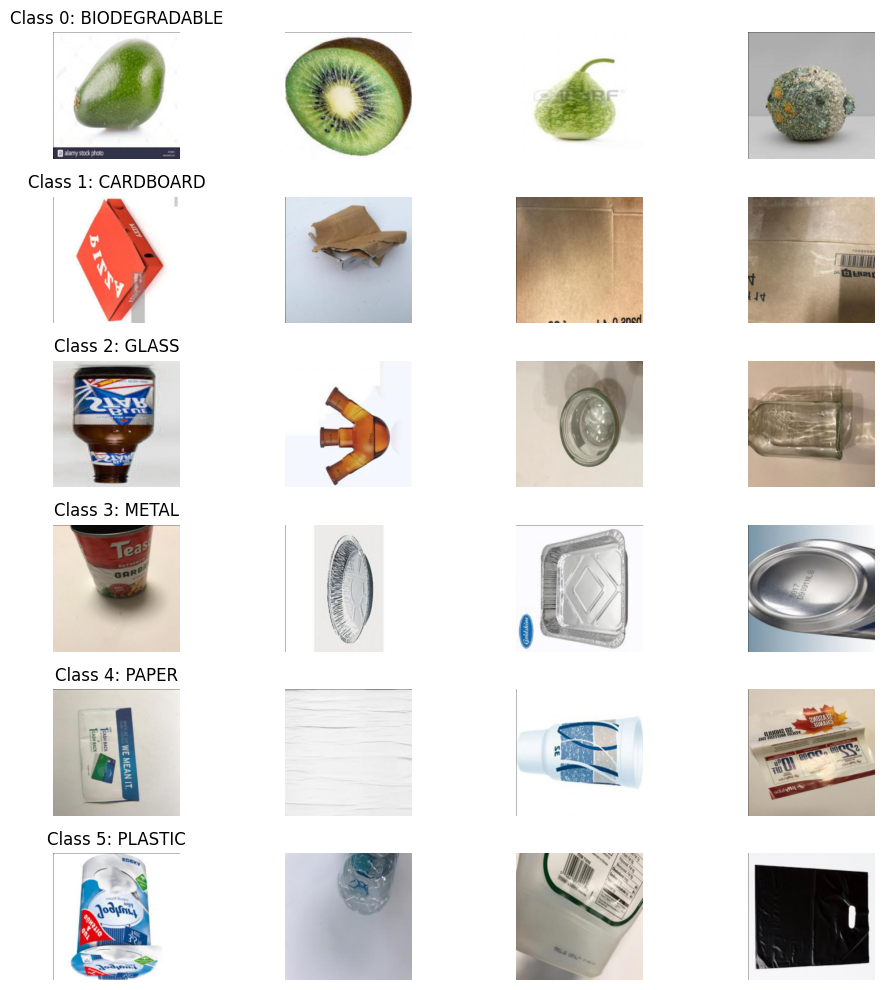

In [ ]:

import matplotlib.pyplot as plt

# Function to collect images for each class
def collect_images_by_class(dataset, num_images=4):
    class_images = {}
    for img, label in dataset:
        if label not in class_images:
            class_images[label] = []
        if len(class_images[label]) < num_images:
            class_images[label].append(img)
        if all(len(images) == num_images for images in class_images.values()):
            break
    return class_images

# Collect images
class_images = collect_images_by_class(train_dataset, num_images=4)

class_names = ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']


# Plot images
def plot_images(class_images):
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, 4, figsize=(10, 10))
    for class_id, images in class_images.items():
        for i, img in enumerate(images):
            ax = axes[class_id, i] if num_classes > 1 else axes[i]
            img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
            img = img.numpy()
            ax.imshow(img)
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Class {class_id}: {class_names[class_id]}')
    plt.tight_layout()
    plt.show()

# Plot the collected images
plot_images(class_images)


In [ ]:
epochs = 1

stw.pytorch_tools.set_random_seed(seed=0)

model = model = stw.models.transfer_learning_torchvision.initialize_effnetb2(out_features=6 , dropout= 0.2)
device = stw.pytorch_tools.get_device()
model = model.to(device)
model = stw.pytorch_tools.enable_multi_gpu(model)

loss_fn = torch.nn.CrossEntropyLoss()
task_type = 'classification'
metrics = stw.customized_metrics.classification_metrics # Accuracy, Recall, Precision, F1; evaluated per epoch


optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
early_stopping = stw.workflow.EarlyStopping(patience=8)
metrics = stw.customized_metrics.regression_metrics
result = stw.workflow.train(model=model,
                                  train_dataloader=train_loader,
                                  validation_dataloader=valid_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  metrics=metrics,
                                  task_type=task_type,
                                  epochs=epochs,
                                  early_stopping=early_stopping,
                                  save_freq=2,
                                  device=device)

(◕‿◕✿) Using 1 GPUs.


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(◕‿◕✿) Epoch 1: Initial Validation loss (0.633369).
    (◕‿◕✿) Epoch 1: Save model to model_checkpoint.pt.
